# Machine Learning Models for SCOPE: Ridge Classifier
Models will be coded here, but the official write up will be in the RMarkdown document.

In [ ]:
# load the data files
import pandas as pd
import numpy as np
from pymodelutils import utils

logs = pd.read_csv("data/metis_logs.csv")
logs.head()

In [2]:
# filter down to show the average opinion (0 means no alert, 1 means alert)
logs['run_date'] = logs['run_date'].astype('datetime64[ns]')
logs['is_alert'] = (np.where(logs['is_alert'] == 'f', 0, 1))
logs = logs.groupby(['series', 'kpi', 'run_date']).mean().round(0).reset_index()
logs['is_campaign'] = np.where(logs['campaign_id'] > 0, 1, 0)
logs = logs.drop(columns=['client_id', 'partner_id', 'campaign_id'])
logs['is_alert'].describe()

count    9674.000000
mean        0.166425
std         0.372481
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: is_alert, dtype: float64

In [ ]:
AS_data = pd.read_csv("data/python_AS.csv")
AS_data.head()

In [ ]:
TS_data = pd.read_csv("data/python_TS.csv")
TS_data.head()

In [ ]:
RexT_data = pd.read_csv("data/python_RexT.csv")
RexT_data.head()

## Data Prep
R has already filtered down the data to the days we are going to use and marked what is disqualified. We still have to handle the feature selection and one-hot encoding of select columns though. We also need to normalize it since out KPIs behave quite differently.

In [ ]:
# add column for AS to tell if it is campaign level or not
AS_data['is_campaign'] = np.where(AS_data['campaign_id'] > 0, 1, 0)

# drop the data we don't need for the model or for matching back to the logs
AS_keep_columns = ['series', 'day', 'run_date', 'kpi', 'value', 'disqualified', 'is_campaign']
TS_keep_columns = ['series', 'day', 'run_date', 'site_type', 'event_name', 
                   'kpi', 'value', 'disqualified']
RexT_drop_columns = ['ranking',
                    'day_of_week',
                    'day_of_month',
                    'month_of_year',
                    'day_of_year',
                    'week_of_year']

AS_data = AS_data[AS_keep_columns]
TS_data = TS_data[TS_keep_columns]
RexT_data = RexT_data.drop(columns=RexT_drop_columns)

In [ ]:
AS_data.head()

In [ ]:
TS_data.head()

In [ ]:
RexT_data.head()

In [ ]:
# add a new column to determine how many days before the run_date the day column entry is
# this will enable us to pivot that data into separate columns for the features of our model
utils.prep_dates(AS_data)
utils.prep_dates(TS_data)
utils.prep_dates(RexT_data)

In [ ]:
# inner joins to logs
AS_data = pd.merge(AS_data, logs, on=['series', 'run_date', 'kpi', 'is_campaign'], how='inner')
TS_data = pd.merge(TS_data, logs, on=['series', 'run_date', 'kpi'], how='inner')
RexT_data = pd.merge(RexT_data, logs, on=['series', 'run_date', 'kpi'], how='inner')

In [ ]:
# filter out the disqualified data (AS and TS data only)
AS_disqualified = AS_data[AS_data.disqualified]
TS_disqualified = TS_data[TS_data.disqualified]

# valid for model (AS and TS data only)
valid_AS_raw = AS_data[~(AS_data.disqualified)]
valid_TS_raw = TS_data[~(TS_data.disqualified)]

# keep a copy of the raw RexT data
RexT_data_raw = RexT_data.copy(deep=True)

In [ ]:
# final preparations to the data shape for use in the model
valid_AS = utils.data_prep_pipeline(valid_AS_raw.copy(), 
                                      indices=['series', 'run_date', 'kpi', 'is_campaign', 'is_alert'], 
                                      cols=['kpi'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'])
disqualified_AS = utils.data_prep_pipeline(AS_disqualified.copy(), 
                                          indices=['series', 'run_date', 'kpi', 'is_campaign', 'is_alert'], 
                                          cols=['kpi'],
                                          scaling_method=['standardize', 'min_max', 'percent_of_mean'])
valid_TS = utils.data_prep_pipeline(valid_TS_raw.copy(), 
                                      indices=['series', 'run_date', 'site_type', 'event_name', 'is_alert'], 
                                      cols=['site_type', 'event_name'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'])
disqualified_TS = utils.data_prep_pipeline(TS_disqualified.copy(), 
                                          indices=['series', 'run_date', 'site_type', 'event_name', 'is_alert'], 
                                          cols=['site_type', 'event_name'],
                                          scaling_method=['standardize', 'min_max', 'percent_of_mean'])
valid_RexT = utils.data_prep_pipeline(utils.clean_regions(RexT_data), 
                                       indices=['isCountry', 'isSubregion', 'isRegion', 
                                                'series', 'run_date', 'is_alert'], 
                                       cols=['series'],
                                       scaling_method=['standardize', 'min_max', 'percent_of_mean'])

In [ ]:
# for the TS data we need to drop event_name_SITE LEVEL because it will always be the same as site_type_SITE LEVEL
valid_TS = {key : value.drop(columns='event_name_SITE LEVEL') for key, value in valid_TS.items()}

# add back missing columns for the disqualified data
disqualified_TS['min_max']['time_delta_24'], disqualified_TS['min_max']['time_delta_25'] = (0,0)
disqualified_TS['min_max']['site_type_SITE LEVEL'], disqualified_TS['min_max']['site_type_aios'] = (0,0)
disqualified_TS['min_max']['time_delta_diff_23'], disqualified_TS['min_max']['time_delta_diff_24'] = (0,0)

In [ ]:
valid_AS['min_max'].head()

In [ ]:
valid_TS['percent_of_mean'].head()

In [ ]:
valid_RexT['standardize'].head()

## Modelling
Now that all the data is prepped, we can start building some logistic regression models to test on. We also need to split our data into a test and train set being careful that we have an equal proportion of anomalies in each (because they are very few, we have to make sure we don't train or test the model on all the anomalies while the other gets none).

### Split Data into Train and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

# scaling method to test
AS_scaler = 'min_max'
TS_scaler = 'min_max'
RexT_scaler = 'min_max'

# separate out data into feature matrices and target arrays
AS_features = valid_AS[AS_scaler][[col for col in valid_AS[AS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]] # this needs to be the model features
AS_targets = valid_AS[AS_scaler]['is_alert'] # this needs to be the results from the logs (only)

TS_features = valid_TS[TS_scaler][[col for col in valid_TS[TS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]]
TS_targets = valid_TS[TS_scaler]['is_alert']

RexT_features = valid_RexT[RexT_scaler][[col for col in valid_RexT[RexT_scaler].columns 
                           if col not in ['run_date', 'is_alert']]]
RexT_targets = valid_RexT[RexT_scaler]['is_alert']
test_RexT_features = RexT_features.drop(columns=[col for col in RexT_features.columns 
                                                 if 'series' in col
                                                or col in ['isCountry', 'isSubregion', 'isRegion']])

# split into a train and test set without differences
AS_X_train, AS_X_test, AS_y_train, AS_y_test = train_test_split(AS_features[[col for col in AS_features.columns 
                                                                             if 'diff' not in col]], 
                                                                AS_targets, 
                                                                test_size=0.2, 
                                                                random_state=25)
TS_X_train, TS_X_test, TS_y_train, TS_y_test = train_test_split(TS_features[[col for col in TS_features.columns 
                                                                             if 'diff' not in col]], 
                                                                TS_targets, 
                                                                test_size=0.2, 
                                                                random_state=25)
RexT_X_train, RexT_X_test, RexT_y_train, RexT_y_test = train_test_split(test_RexT_features[[col for col in 
                                                                                            test_RexT_features.columns
                                                                                            if 'diff' not in col]], 
                                                                        RexT_targets, 
                                                                        test_size=0.5, 
                                                                        random_state=25)

# split into a train and test set with differences
AS_X_train_diff, AS_X_test_diff, AS_y_train_diff, AS_y_test_diff = train_test_split(AS_features, 
                                                                                    AS_targets, 
                                                                                    test_size=0.2, 
                                                                                    random_state=25)
TS_X_train_diff, TS_X_test_diff, TS_y_train_diff, TS_y_test_diff = train_test_split(TS_features, 
                                                                                    TS_targets, 
                                                                                    test_size=0.2, 
                                                                                    random_state=25)
RexT_X_train_diff, RexT_X_test_diff, RexT_y_train_diff, RexT_y_test_diff = train_test_split(test_RexT_features, 
                                                                                            RexT_targets, 
                                                                                            test_size=0.5, 
                                                                                            random_state=25)

Let's make sure that we have similar percentage of anomalies in our test and train sets. 

In [19]:
# AS
print('Total alerts in training set: ' + str(AS_y_train.sum()))
print('Total alerts in test set: ' + str(AS_y_test.sum()))
pd.DataFrame({'train' : AS_y_train.value_counts(normalize=True), 
              'test' : AS_y_test.value_counts(normalize=True)})

Total alerts in training set: 831.0
Total alerts in test set: 215.0


,test,train
0.0,0.782828,0.790045
1.0,0.217172,0.209955


In [20]:
# TS
print('Total alerts in training set: ' + str(TS_y_train.sum()))
print('Total alerts in test set: ' + str(TS_y_test.sum()))
pd.DataFrame({'train' : TS_y_train.value_counts(normalize=True), 
              'test' : TS_y_test.value_counts(normalize=True)})

Total alerts in training set: 237.0
Total alerts in test set: 58.0


,test,train
0.0,0.916667,0.91484
1.0,0.083333,0.08516


In [21]:
# RexT
print('Total alerts in training set: ' + str(RexT_y_train.sum()))
print('Total alerts in test set: ' + str(RexT_y_test.sum()))
pd.DataFrame({'train' : RexT_y_train.value_counts(normalize=True), 
              'test' : RexT_y_test.value_counts(normalize=True)})

Total alerts in training set: 9.0
Total alerts in test set: 13.0


,test,train
0.0,0.868687,0.909091
1.0,0.131313,0.090909


### Ridge Classifier without Differences

In [22]:
%%capture 
# ^ don't print errors about precision, recall, F1-score being 0

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, fbeta_score, zero_one_loss

ridge = RidgeClassifier(normalize=False, random_state=42)

parameters = {'alpha':[0.1, 0.5, 1, 5],
             'fit_intercept' : [True, False],
             'class_weight' : ['balanced', None]}

scoring = {'auc': 'roc_auc',
           # only reports on alerts flagged
           'precision_binary' : make_scorer(precision_score, average='binary'), 
           # global count of everything like confusion matrix
           'precision_micro' : make_scorer(precision_score, average='micro'), 
           # same as macro but with a weighted average to account for imbalance of the classes
           'precision_weighted' : make_scorer(precision_score, average='weighted'),
          'recall_weighted' : make_scorer(recall_score, average='weighted'),
          'recall_binary' : make_scorer(recall_score, average='binary'),
          'recall_micro' : make_scorer(recall_score, average='micro'),
          'f1_score_weighted' : make_scorer(f1_score, average='weighted'),
          'f1_score_binary' : make_scorer(f1_score, average='binary'),
          'f1_score_micro' : make_scorer(f1_score, average='micro'),
           # emphasize recall more
          'f2_score_weighted' : make_scorer(fbeta_score, beta=2, average='weighted'), 
          'f2_score_binary' : make_scorer(fbeta_score, beta=2, average='binary'),
          'f2_score_micro' : make_scorer(fbeta_score, beta=2, average='micro'),
           # emphasize precision more
          'f0.5_score_weighted' : make_scorer(fbeta_score, beta=0.5, average='weighted'), 
          'f0.5_score_binary' : make_scorer(fbeta_score, beta=0.5, average='binary'),
          'f0.5_score_micro' : make_scorer(fbeta_score, beta=0.5, average='micro'),
           # percent of misclassifications
          'zero_one_loss_normalized' : make_scorer(zero_one_loss, greater_is_better=False), 
           # number of misclassifications
          'zero_one_loss_count' : make_scorer(zero_one_loss, greater_is_better=False, normalize=False), 
          'accuracy' : 'accuracy'}

# pick '_weighted' if you want to be right on each class proportionally 
# ('macro' isn't really appropriate due to the class imbalance)
# pick '_binary' if you want to perform best on the alert class
# pick '_micro' to count globally all TP, FP, TN, FN (like confusion matrix)
# so for our purposes 'f1_score' with one of the above is likely to be the best
refit_AS = 'precision_micro'
refit_TS = 'precision_micro'
refit_RexT = 'auc'

AS_ridge_grid = GridSearchCV(estimator=ridge, param_grid=parameters, 
                                scoring=scoring, refit=refit_AS, return_train_score=True)
TS_ridge_grid = GridSearchCV(estimator=ridge, param_grid=parameters, 
                                scoring=scoring, refit=refit_TS, return_train_score=True)
RexT_ridge_grid = GridSearchCV(estimator=ridge, param_grid=parameters, 
                                  scoring=scoring, refit=refit_RexT, return_train_score=True)

# fit the models to find the best version
AS_ridge_model = AS_ridge_grid.fit(AS_X_train, AS_y_train)
TS_ridge_model = TS_ridge_grid.fit(TS_X_train, TS_y_train)
RexT_ridge_model = RexT_ridge_grid.fit(RexT_X_train, RexT_y_train)

#### Best Models
##### AS

In [23]:
print(AS_ridge_model.best_estimator_)
print(refit_AS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(AS_ridge_model.best_score_))
for col, coef in zip(AS_X_train.columns, AS_ridge_model.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

RidgeClassifier(alpha=1, class_weight=None, copy_X=True, fit_intercept=False,
        max_iter=None, normalize=False, random_state=42, solver='auto',
        tol=0.001)
precision_micro (Mean cross-validated score of the best_estimator): 0.7950985346134412
is_campaign	0.06
time_delta_01	0.1
time_delta_02	0.04
time_delta_03	0.02
time_delta_04	0.0
time_delta_05	0.0
time_delta_06	0.03
time_delta_07	-0.01
time_delta_08	-0.01
time_delta_09	0.0
time_delta_10	0.0
time_delta_11	0.0
time_delta_12	0.03
time_delta_13	0.01
time_delta_14	-0.02
time_delta_15	0.0
time_delta_16	-0.01
time_delta_17	-0.0
time_delta_18	0.02
time_delta_19	-0.0
time_delta_20	-0.01
time_delta_21	-0.01
time_delta_22	0.01
time_delta_23	-0.01
time_delta_24	-0.01
time_delta_25	-0.0
kpi_clicks	-0.51
kpi_client_rext	-0.64
kpi_conversions	-0.66
kpi_cos	-0.64
kpi_cr	-0.68
kpi_ctr	-0.81
kpi_displays	-0.5
kpi_margin	-1.11
kpi_order_value	-0.64
kpi_rext_euro	-0.96
kpi_spend	-0.54
kpi_tac	-0.96


##### TS

In [24]:
print(TS_ridge_model.best_estimator_)
print(refit_TS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(TS_ridge_model.best_score_))
for col, coef in zip(TS_X_train.columns, TS_ridge_model.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

RidgeClassifier(alpha=0.1, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=42, solver='auto',
        tol=0.001)
precision_micro (Mean cross-validated score of the best_estimator): 0.9198706431908013
time_delta_01	0.09
time_delta_02	0.02
time_delta_03	-0.01
time_delta_04	-0.05
time_delta_05	0.0
time_delta_06	0.01
time_delta_07	-0.0
time_delta_08	-0.02
time_delta_09	-0.02
time_delta_10	0.01
time_delta_11	0.01
time_delta_12	0.02
time_delta_13	0.0
time_delta_14	-0.01
time_delta_15	0.0
time_delta_16	0.02
time_delta_17	-0.0
time_delta_18	0.03
time_delta_19	0.03
time_delta_20	0.04
time_delta_21	-0.02
time_delta_22	-0.02
time_delta_23	0.01
time_delta_24	0.03
time_delta_25	0.0
site_type_SITE LEVEL	0.02
site_type_aa	0.02
site_type_aios	-0.05
site_type_d	-0.04
site_type_m	0.05
site_type_t	-0.0
event_name_basket	-0.03
event_name_homepage	-0.03
event_name_listing	0.01
event_name_product	-0.01
event_name_sales	-0.04
event_name_search	0.09


##### RexT

In [25]:
print(RexT_ridge_model.best_estimator_)
print(refit_RexT + ' (Mean cross-validated score of the best_estimator): ' + \
      str(RexT_ridge_model.best_score_))
for col, coef in zip(RexT_X_train.columns, RexT_ridge_model.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

RidgeClassifier(alpha=0.5, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=42, solver='auto',
        tol=0.001)
auc (Mean cross-validated score of the best_estimator): 0.937037037037037
time_delta_01	0.66
time_delta_02	-0.4
time_delta_03	0.01
time_delta_04	-0.07
time_delta_05	0.02
time_delta_06	0.03
time_delta_07	0.04
time_delta_08	-0.05
time_delta_09	-0.04
time_delta_10	-0.12
time_delta_11	0.07
time_delta_12	0.02
time_delta_13	0.07
time_delta_14	-0.17
time_delta_15	0.03
time_delta_16	-0.03
time_delta_17	0.15
time_delta_18	-0.11
time_delta_19	-0.07
time_delta_20	-0.09
time_delta_21	0.09
time_delta_22	-0.04
time_delta_23	0.09
time_delta_24	-0.16
time_delta_25	0.03
time_delta_26	0.24
time_delta_27	-0.14
time_delta_28	-0.08
time_delta_29	-0.06
time_delta_30	0.08


#### Model Evaluation
##### ROC Curve

In [27]:
from sklearn.metrics import roc_curve, auc

AS_y_prob_fit = AS_ridge_model.decision_function(AS_X_test)
TS_y_prob_fit = TS_ridge_model.decision_function(TS_X_test)
RexT_y_prob_fit = RexT_ridge_model.decision_function(RexT_X_test)

AS_ridge_roc_curve = roc_curve(AS_y_test, AS_y_prob_fit, pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_ridge_roc_curve_AUC = auc(AS_ridge_roc_curve[0], AS_ridge_roc_curve[1]) # needs fpr, tpr
TS_ridge_roc_curve = roc_curve(TS_y_test, TS_y_prob_fit, pos_label=1)
TS_ridge_roc_curve_AUC = auc(TS_ridge_roc_curve[0], TS_ridge_roc_curve[1])
RexT_ridge_roc_curve = roc_curve(RexT_y_test, RexT_y_prob_fit, pos_label=1)
RexT_ridge_roc_curve_AUC = auc(RexT_ridge_roc_curve[0], RexT_ridge_roc_curve[1])

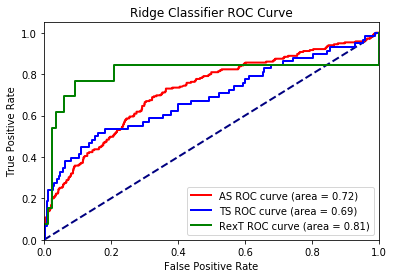

In [28]:
# ROC Curve without 1 period differences
utils.model_roc_curves(roc_data_dict={'AS' : AS_ridge_roc_curve, 
                                'TS' : TS_ridge_roc_curve, 
                                'RexT' : RexT_ridge_roc_curve}, 
                 auc_dict={'AS' : AS_ridge_roc_curve_AUC, 
                           'TS' : TS_ridge_roc_curve_AUC, 
                           'RexT' : RexT_ridge_roc_curve_AUC}, 
                 method_name='Ridge Classifier')

##### Confusion Matrix

TP to FP ratio: inf


C:\Users\s.molin\scope_model_case_study\pymodelutils\utils.py:259: RuntimeWarning: divide by zero encountered in longlong_scalars
  print('TP to FP ratio: ' + str(round(mat[1,1] / mat[0,1], 2)))


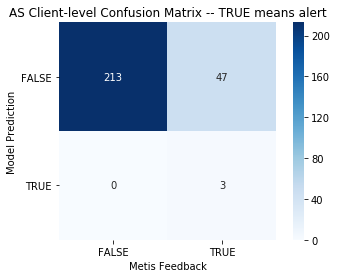

TP to FP ratio: 5.0


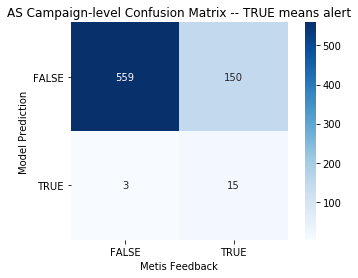

TP to FP ratio: 6.0


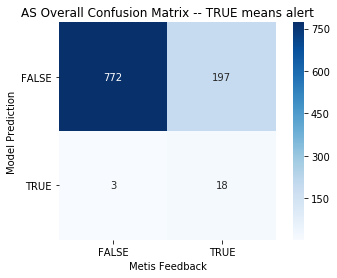

In [35]:
AS_threshold = 0.001
utils.confusion_matrix_visual(AS_y_test[AS_X_test.is_campaign == 0], 
                        AS_ridge_model.decision_function(AS_X_test[AS_X_test.is_campaign == 0]) \
                        >= AS_threshold, 'AS Client-level')
utils.confusion_matrix_visual(AS_y_test[AS_X_test.is_campaign == 1], 
                        AS_ridge_model.decision_function(AS_X_test[AS_X_test.is_campaign == 1]) \
                        >= AS_threshold, 'AS Campaign-level')
utils.confusion_matrix_visual(AS_y_test, 
                        AS_ridge_model.decision_function(AS_X_test) \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 1.0


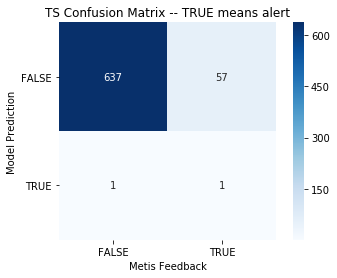

In [40]:
TS_threshold = 0.0000001
utils.confusion_matrix_visual(TS_y_test, 
                        TS_ridge_model.decision_function(TS_X_test) \
                        >= TS_threshold,
                        'TS')

TP to FP ratio: 2.0


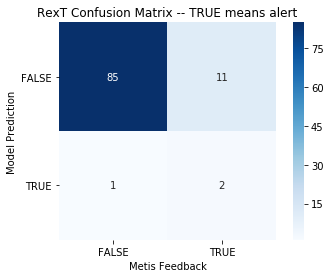

In [44]:
RexT_threshold = 0.000000001
utils.confusion_matrix_visual(RexT_y_test, 
                        RexT_ridge_model.decision_function(RexT_X_test) \
                        >= RexT_threshold,
                        'RexT')

On disqualified data.

TP to FP ratio: 1.02


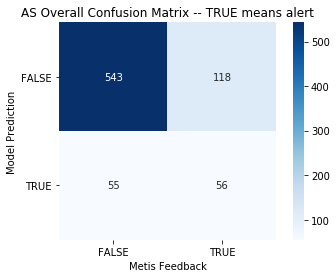

In [45]:
utils.confusion_matrix_visual(disqualified_AS['min_max']['is_alert'], 
                        AS_ridge_model.decision_function(disqualified_AS['min_max'].\
                                                                   drop([col for col in disqualified_AS['min_max'].columns
                                                                        if 'diff' in col or col in ['run_date', 'series', 'is_alert']], axis=1)) \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: nan


C:\Users\s.molin\scope_model_case_study\pymodelutils\utils.py:259: RuntimeWarning: invalid value encountered in longlong_scalars
  print('TP to FP ratio: ' + str(round(mat[1,1] / mat[0,1], 2)))


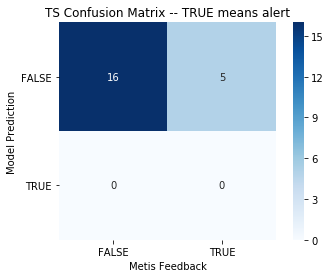

In [46]:
disqualified_TS['min_max']['time_delta_24'], disqualified_TS['min_max']['time_delta_25'] = (0,0)
disqualified_TS['min_max']['site_type_SITE LEVEL'], disqualified_TS['min_max']['site_type_aios'] = (0,0)
utils.confusion_matrix_visual(disqualified_TS['min_max']['is_alert'], 
                        TS_ridge_model.decision_function(disqualified_TS['min_max'].\
                                                                   drop([col for col in disqualified_TS['min_max'].columns
                                                                        if 'diff' in col or col in ['run_date', 'series', 'is_alert']], axis=1)) \
                        >= TS_threshold,
                        'TS')

#### Metrics

In [47]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test, 
                                       'TS' : TS_y_test, 
                                       'RexT' : RexT_y_test},
                         y_pred_dict={'AS' : 
                                      AS_ridge_model.decision_function(AS_X_test) >= \
                                      AS_threshold, 
                                      'TS' : 
                                      TS_ridge_model.decision_function(TS_X_test) >= \
                                      TS_threshold, 
                                      'RexT' : 
                                      RexT_ridge_model.decision_function(RexT_X_test) >= \
                                      RexT_threshold})

AS results
             precision    recall  f1-score   support

      False       0.80      1.00      0.89       775
       True       0.86      0.08      0.15       215

avg / total       0.81      0.80      0.73       990

Percent misclassified: 20.2%
Count misclassified: 200
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.92      1.00      0.96       638
       True       0.50      0.02      0.03        58

avg / total       0.88      0.92      0.88       696

Percent misclassified: 8.33%
Count misclassified: 58
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.89      0.99      0.93        86
       True       0.67      0.15      0.25        13

avg / total       0.86      0.88      0.84        99

Percent misclassified: 12.12%
Count misclassified: 12


### Logistic Regression with Differences

In [48]:
%%capture 
# ^ don't print errors about precision, recall, F1-score being 0

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, fbeta_score, zero_one_loss

ridge_diff = RidgeClassifier(normalize=False, random_state=42)

parameters = {'alpha':[0.1, 0.5, 1, 5],
             'fit_intercept' : [True, False],
             'class_weight' : ['balanced', None]}

scoring = {'auc': 'roc_auc',
           'precision_binary' : make_scorer(precision_score, average='binary'), 
           'precision_micro' : make_scorer(precision_score, average='micro'), 
           'precision_weighted' : make_scorer(precision_score, average='weighted'),
          'recall_weighted' : make_scorer(recall_score, average='weighted'),
          'recall_binary' : make_scorer(recall_score, average='binary'),
          'recall_micro' : make_scorer(recall_score, average='micro'),
          'f1_score_weighted' : make_scorer(f1_score, average='weighted'),
          'f1_score_binary' : make_scorer(f1_score, average='binary'),
          'f1_score_micro' : make_scorer(f1_score, average='micro'),
          'f2_score_weighted' : make_scorer(fbeta_score, beta=2, average='weighted'), 
          'f2_score_binary' : make_scorer(fbeta_score, beta=2, average='binary'),
          'f2_score_micro' : make_scorer(fbeta_score, beta=2, average='micro'),
          'f0.5_score_weighted' : make_scorer(fbeta_score, beta=0.5, average='weighted'), 
          'f0.5_score_binary' : make_scorer(fbeta_score, beta=0.5, average='binary'),
          'f0.5_score_micro' : make_scorer(fbeta_score, beta=0.5, average='micro'),
          'zero_one_loss_normalized' : make_scorer(zero_one_loss, greater_is_better=False), 
          'zero_one_loss_count' : make_scorer(zero_one_loss, greater_is_better=False, normalize=False), 
          'accuracy' : 'accuracy'}

# pick '_weighted' if you want to be right on each class proportionally 
# ('macro' isn't really appropriate due to the class imbalance)
# pick '_binary' if you want to perform best on the alert class
# pick '_micro' to count globally all TP, FP, TN, FN (like confusion matrix)
# so for our purposes 'f1_score' with one of the above is likely to be the best
refit_AS = 'precision_weighted'
refit_TS = 'precision_micro'
refit_RexT = 'auc'

AS_ridge_diff_grid = GridSearchCV(estimator=ridge_diff, param_grid=parameters, 
                                scoring=scoring, refit=refit_AS, return_train_score=True)
TS_ridge_diff_grid = GridSearchCV(estimator=ridge_diff, param_grid=parameters, 
                                scoring=scoring, refit=refit_TS, return_train_score=True)
RexT_ridge_diff_grid = GridSearchCV(estimator=ridge_diff, param_grid=parameters, 
                                  scoring=scoring, refit=refit_RexT, return_train_score=True)

# fit the models to find the best version
AS_ridge_model_diff = AS_ridge_diff_grid.fit(AS_X_train_diff, AS_y_train_diff)
TS_ridge_model_diff = TS_ridge_diff_grid.fit(TS_X_train_diff, TS_y_train_diff)
RexT_ridge_model_diff = RexT_ridge_diff_grid.fit(RexT_X_train_diff, RexT_y_train_diff)

#### Best Models
##### AS

In [49]:
print(AS_ridge_model_diff.best_estimator_)
print(refit_AS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(AS_ridge_model_diff.best_score_))
for col, coef in zip(AS_X_train_diff.columns, AS_ridge_model_diff.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

RidgeClassifier(alpha=0.1, class_weight='balanced', copy_X=True,
        fit_intercept=True, max_iter=None, normalize=False,
        random_state=42, solver='auto', tol=0.001)
precision_weighted (Mean cross-validated score of the best_estimator): 0.7681255474122398
is_campaign	0.12
time_delta_01	0.1
time_delta_02	0.07
time_delta_03	0.03
time_delta_04	0.02
time_delta_05	0.01
time_delta_06	0.04
time_delta_07	0.0
time_delta_08	0.0
time_delta_09	-0.02
time_delta_10	0.02
time_delta_11	-0.01
time_delta_12	0.05
time_delta_13	-0.02
time_delta_14	0.01
time_delta_15	0.01
time_delta_16	-0.03
time_delta_17	-0.05
time_delta_18	0.09
time_delta_19	-0.02
time_delta_20	-0.04
time_delta_21	0.01
time_delta_22	0.05
time_delta_23	-0.02
time_delta_24	-0.05
time_delta_25	0.04
kpi_clicks	0.29
kpi_client_rext	0.14
kpi_conversions	0.13
kpi_cos	0.13
kpi_cr	0.06
kpi_ctr	-0.09
kpi_displays	0.3
kpi_margin	-0.65
kpi_order_value	0.12
kpi_rext_euro	-0.33
kpi_spend	0.24
kpi_tac	-0.33
time_delta_diff_24	0.18
time_delta_

##### TS

In [50]:
print(TS_ridge_model_diff.best_estimator_)
print(refit_TS + ' (Mean cross-validated score of the best_estimator): ' + \
      str(TS_ridge_model_diff.best_score_))
for col, coef in zip(TS_X_train_diff.columns, TS_ridge_model_diff.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

RidgeClassifier(alpha=0.1, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=42, solver='auto',
        tol=0.001)
precision_micro (Mean cross-validated score of the best_estimator): 0.9191519942508085
time_delta_01	0.08
time_delta_02	0.04
time_delta_03	-0.01
time_delta_04	0.0
time_delta_05	-0.07
time_delta_06	-0.03
time_delta_07	0.07
time_delta_08	-0.04
time_delta_09	-0.08
time_delta_10	0.04
time_delta_11	-0.07
time_delta_12	0.09
time_delta_13	0.01
time_delta_14	-0.01
time_delta_15	-0.05
time_delta_16	0.05
time_delta_17	-0.01
time_delta_18	0.0
time_delta_19	-0.01
time_delta_20	0.02
time_delta_21	0.01
time_delta_22	0.02
time_delta_23	0.01
time_delta_24	0.06
time_delta_25	-0.04
site_type_SITE LEVEL	0.03
site_type_aa	0.01
site_type_aios	-0.05
site_type_d	-0.03
site_type_m	0.05
site_type_t	0.0
event_name_basket	-0.03
event_name_homepage	-0.03
event_name_listing	0.01
event_name_product	-0.02
event_name_sales	-0.04
event_name_search	0.0

##### RexT

In [51]:
print(RexT_ridge_model_diff.best_estimator_)
print(refit_RexT + ' (Mean cross-validated score of the best_estimator): ' + \
      str(RexT_ridge_model_diff.best_score_))
for col, coef in zip(RexT_X_train_diff.columns, RexT_ridge_model_diff.best_estimator_.coef_[0]):
    print(col + '\t' + str(round(coef, 2)))

RidgeClassifier(alpha=5, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=42, solver='auto',
        tol=0.001)
auc (Mean cross-validated score of the best_estimator): 0.9370370370370369
time_delta_01	0.28
time_delta_02	-0.02
time_delta_03	0.08
time_delta_04	-0.07
time_delta_05	0.01
time_delta_06	-0.02
time_delta_07	-0.01
time_delta_08	-0.03
time_delta_09	-0.02
time_delta_10	-0.07
time_delta_11	0.04
time_delta_12	-0.02
time_delta_13	0.01
time_delta_14	-0.06
time_delta_15	-0.01
time_delta_16	0.04
time_delta_17	0.01
time_delta_18	-0.08
time_delta_19	0.01
time_delta_20	-0.05
time_delta_21	0.03
time_delta_22	0.01
time_delta_23	-0.01
time_delta_24	-0.04
time_delta_25	-0.02
time_delta_26	0.07
time_delta_27	-0.01
time_delta_28	-0.02
time_delta_29	-0.05
time_delta_30	0.01
time_delta_diff_29	-0.05
time_delta_diff_28	-0.05
time_delta_diff_27	-0.04
time_delta_diff_26	0.07
time_delta_diff_25	-0.01
time_delta_diff_24	-0.09
time_delta_diff_23	0

#### Model Evaluation
##### ROC Curve

In [52]:
from sklearn.metrics import roc_curve, auc

AS_y_prob_fit_diff = AS_ridge_model_diff.decision_function(AS_X_test_diff)
TS_y_prob_fit_diff = TS_ridge_model_diff.decision_function(TS_X_test_diff)
RexT_y_prob_fit_diff = RexT_ridge_model_diff.decision_function(RexT_X_test_diff)

AS_ridge_roc_curve_diff = roc_curve(AS_y_test_diff, AS_y_prob_fit_diff, pos_label=1)
AS_ridge_roc_curve_AUC_diff = auc(AS_ridge_roc_curve_diff[0], AS_ridge_roc_curve_diff[1]) # needs fpr, tpr
TS_ridge_roc_curve_diff = roc_curve(TS_y_test_diff, TS_y_prob_fit_diff, pos_label=1)
TS_ridge_roc_curve_AUC_diff = auc(TS_ridge_roc_curve_diff[0], TS_ridge_roc_curve_diff[1])
RexT_ridge_roc_curve_diff = roc_curve(RexT_y_test_diff, RexT_y_prob_fit_diff, pos_label=1)
RexT_ridge_roc_curve_AUC_diff = auc(RexT_ridge_roc_curve_diff[0], RexT_ridge_roc_curve_diff[1])

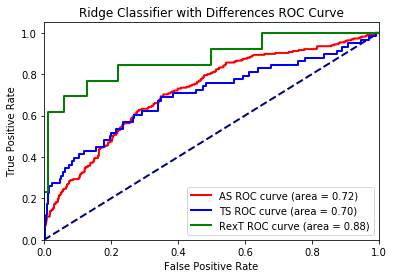

In [53]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_ridge_roc_curve_diff, 
                                'TS' : TS_ridge_roc_curve_diff, 
                                'RexT' : RexT_ridge_roc_curve_diff}, 
                 auc_dict={'AS' : AS_ridge_roc_curve_AUC_diff, 
                           'TS' : TS_ridge_roc_curve_AUC_diff, 
                           'RexT' : RexT_ridge_roc_curve_AUC_diff}, 
                 method_name='Ridge Classifier with Differences')

##### Confusion Matrix

TP to FP ratio: 1.8


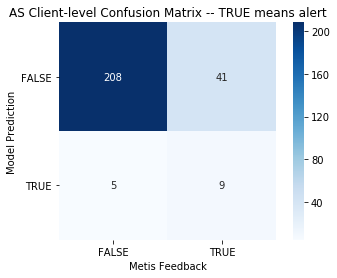

TP to FP ratio: 1.1


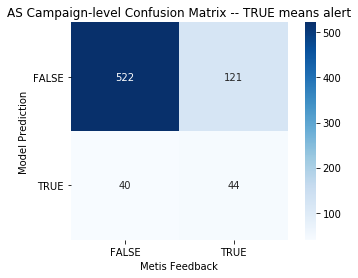

TP to FP ratio: 1.1


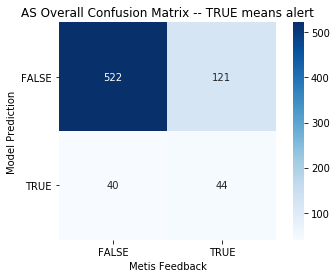

In [55]:
AS_threshold = 0.4
utils.confusion_matrix_visual(AS_y_test_diff[AS_X_test_diff.is_campaign == 0], 
                        AS_ridge_model_diff.decision_function(AS_X_test_diff[AS_X_test_diff.is_campaign == 0]) \
                        >= AS_threshold, 'AS Client-level')
utils.confusion_matrix_visual(AS_y_test_diff[AS_X_test_diff.is_campaign == 1], 
                        AS_ridge_model_diff.decision_function(AS_X_test_diff[AS_X_test_diff.is_campaign == 1]) \
                        >= AS_threshold, 'AS Campaign-level')
utils.confusion_matrix_visual(AS_y_test_diff[AS_X_test_diff.is_campaign == 1], 
                        AS_ridge_model_diff.decision_function(AS_X_test_diff[AS_X_test_diff.is_campaign == 1]) \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 2.0


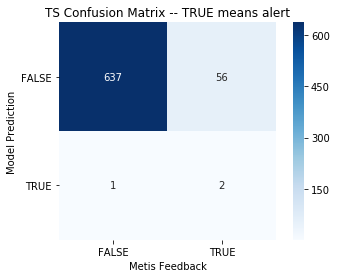

In [59]:
TS_threshold = 0.001
utils.confusion_matrix_visual(TS_y_test_diff, 
                        TS_ridge_model_diff.decision_function(TS_X_test_diff) \
                        >= TS_threshold,
                        'TS')

TP to FP ratio: inf


C:\Users\s.molin\scope_model_case_study\pymodelutils\utils.py:259: RuntimeWarning: divide by zero encountered in longlong_scalars
  print('TP to FP ratio: ' + str(round(mat[1,1] / mat[0,1], 2)))


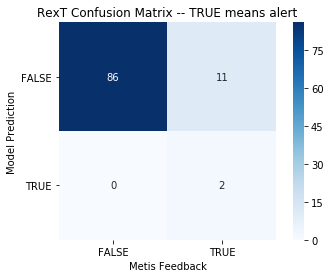

In [61]:
RexT_threshold = 0.01
utils.confusion_matrix_visual(RexT_y_test_diff, 
                        RexT_ridge_model_diff.decision_function(RexT_X_test_diff) \
                        >= RexT_threshold,
                        'RexT')

On disqualified data.

TP to FP ratio: 0.71


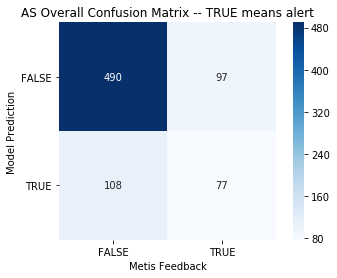

In [62]:
utils.confusion_matrix_visual(disqualified_AS['min_max']['is_alert'], 
                        AS_ridge_model_diff.decision_function(disqualified_AS['min_max'].\
                                                                   drop([col for col in disqualified_AS['min_max'].columns
                                                                        if col in ['run_date', 'series', 'is_alert']], axis=1)) \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 0.0


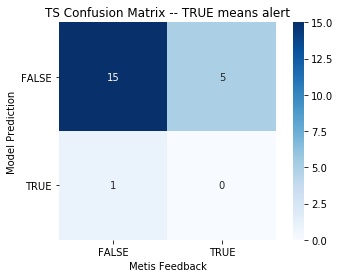

In [64]:
utils.confusion_matrix_visual(disqualified_TS['min_max']['is_alert'], 
                        TS_ridge_model_diff.decision_function(disqualified_TS['min_max'].\
                                                                   drop([col for col in disqualified_TS['min_max'].columns
                                                                        if col in ['run_date', 'series', 'is_alert']], axis=1)) \
                        >= TS_threshold,
                        'TS')

#### Metrics

In [66]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test_diff, 
                                       'TS' : TS_y_test_diff, 
                                       'RexT' : RexT_y_test_diff},
                         y_pred_dict={'AS' : 
                                      AS_ridge_model_diff.decision_function(AS_X_test_diff) >= \
                                      AS_threshold, 
                                      'TS' : 
                                      TS_ridge_model_diff.decision_function(TS_X_test_diff) >= \
                                      TS_threshold, 
                                      'RexT' : 
                                      RexT_ridge_model_diff.decision_function(RexT_X_test_diff) >= \
                                      RexT_threshold})

AS results
             precision    recall  f1-score   support

      False       0.82      0.94      0.88       775
       True       0.54      0.25      0.34       215

avg / total       0.76      0.79      0.76       990

Percent misclassified: 20.91%
Count misclassified: 207
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.92      1.00      0.96       638
       True       0.67      0.03      0.07        58

avg / total       0.90      0.92      0.88       696

Percent misclassified: 8.19%
Count misclassified: 57
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.89      1.00      0.94        86
       True       1.00      0.15      0.27        13

avg / total       0.90      0.89      0.85        99

Percent misclassified: 11.11%
Count misclassified: 11
